<a href="https://colab.research.google.com/github/juanmed/detectron2_instance_segmentation_demo/blob/master/Detectron2_custom_coco_data_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [How to train Detectron2 with Custom COCO Datasets](https://www.dlology.com/blog/how-to-train-detectron2-with-custom-coco-datasets/) | DLology

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

This notebook will help you get started with this framwork by training a instance segmentation model with your custom COCO datasets.

# Install detectron2

In [1]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

Requirement already up-to-date: torch in /usr/local/lib/python3.7/dist-packages (1.8.0+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.7/dist-packages (0.9.0+cu101)
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-jmf2gccf
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-jmf2gccf
     |████████████████████████████████| 645kB 11.5MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3-cp37-none-any.whl size=62334 sha256=f676d3c0cd8909b84fe97666dad2903e0524ac13b36341bb18a600bf26742ad4
  Stored in directory: /tmp/pip-ephem-wheel-cache-la4ua5wf/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
  Created wheel for iopath: filename=iopath-0.1.6-cp37-none-any.whl size=18269 sha256=627c03f02d2f760be3bbb5fca82c8520e9494536976309dddf41de7a12d175b2
  Stored in directory: /root/.cache/pip/wheels/ff/87/55/7513122394822977f993e1798bfebb46730d6183df8db7b283
Successfully built fv

'1.8.0+cu101'

In [2]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 10888 (delta 0), reused 1 (delta 0), pack-reused 10877
Receiving objects: 100% (10888/10888), 4.44 MiB | 27.74 MiB/s, done.
Resolving deltas: 100% (7897/7897), done.
Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 2.2MB 19.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0
  Running setup.py develop for detectron2


In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Train on a custom COCO dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the fruits nuts segmentation dataset](https://github.com/Tony607/mmdetection_instance_segmentation_demo)
which only has 3 classes: data, fig, and hazelnut.
We'll train a segmentation model from an existing model pre-trained on the COCO dataset, available in detectron2's model zoo.

Note that the COCO dataset does not have the "data", "fig" and "hazelnut" categories.

In [2]:
!pip install gdown

In [3]:
import gdown
import shutil
#https://drive.google.com/file/d/14ZcrZ9JbU8_XvCkGvq00xrZt2hioZjGv/view?usp=sharing
url = 'https://drive.google.com/uc?id=14ZcrZ9JbU8_XvCkGvq00xrZt2hioZjGv'
output = 'data.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1VD9svjVJ-1Z4gPK1MWyuPfco6oz9yy9v
To: /content/data.zip
1.38GB [00:19, 71.6MB/s]


'data.zip'

In [4]:
!unzip data.zip > /dev/null

In [ ]:
# download, decompress the data
#!wget https://github.com/Tony607/detectron2_instance_segmentation_demo/releases/download/V0.1/data.zip
#!unzip data.zip > /dev/null

Register the fruits_nuts dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [2]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("fruit_nuts2", {}, "./data/trainval.json", "./data/images")

In [3]:
fruits_nuts_metadata = MetadataCatalog.get("fruit_nuts2")
dataset_dicts = DatasetCatalog.get("fruit_nuts2")

[03/14 23:14:29 d2.data.datasets.coco]: Loaded 334 images in COCO format from ./data/trainval.json


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



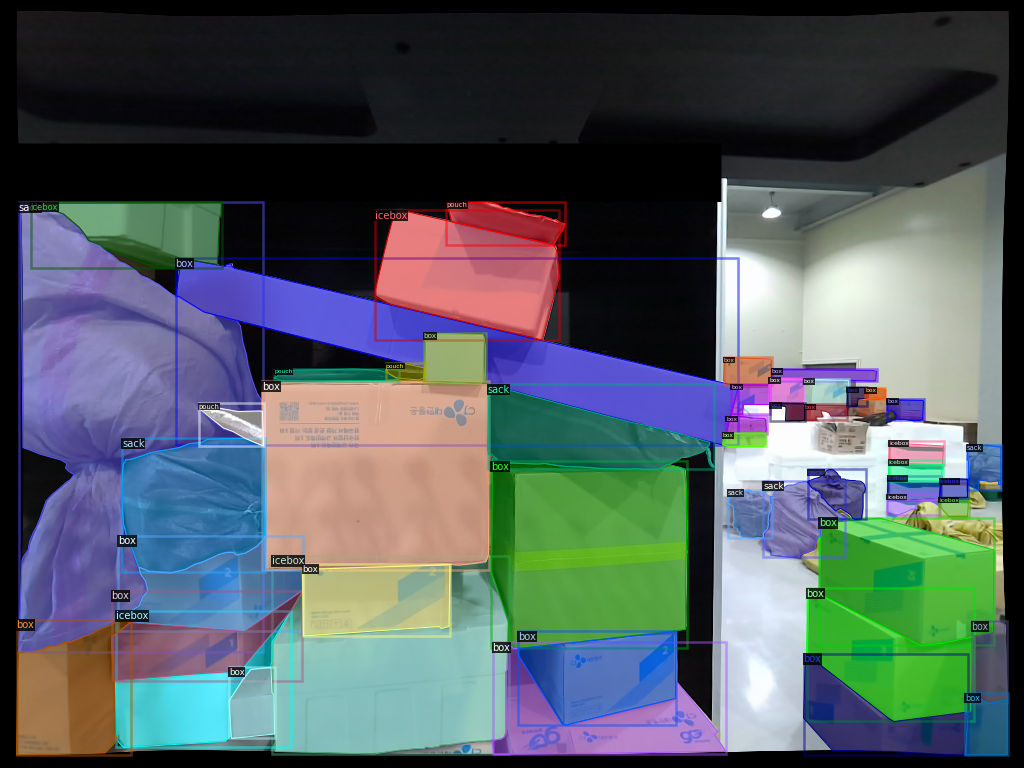

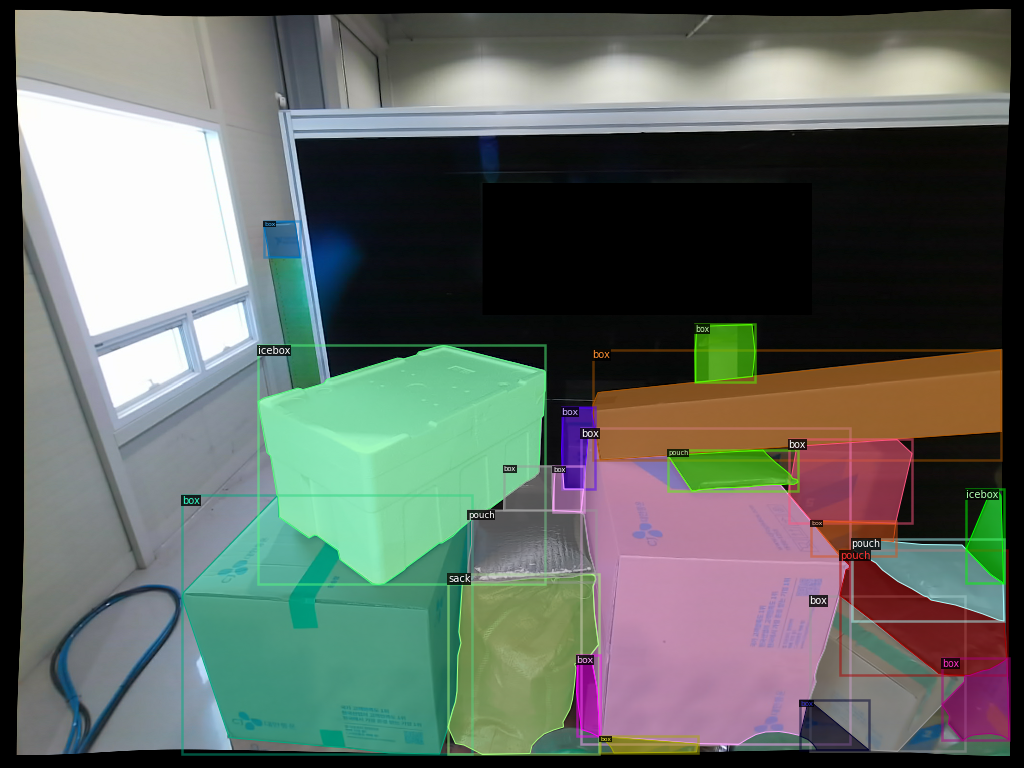

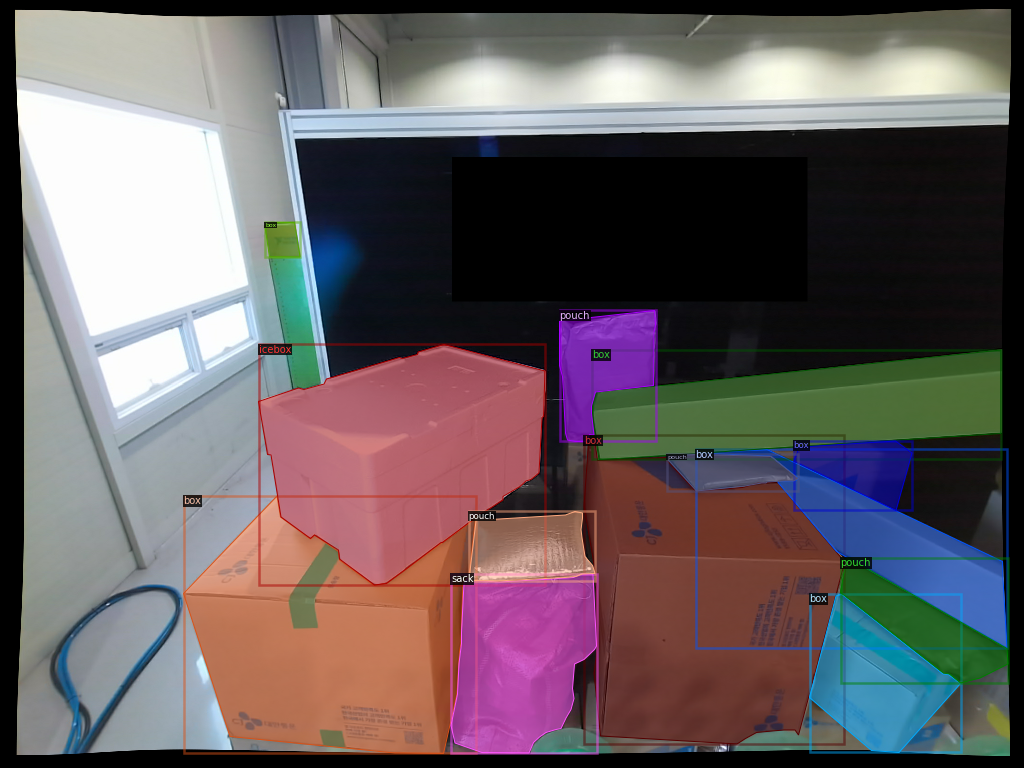

In [4]:
import random

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=fruits_nuts_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the fruits_nuts dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU.


In [11]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("fruit_nuts2",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 1000   # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # 3 classes (data, fig, hazelnut)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/14 23:17:06 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[03/14 23:17:06 d2.engine.train_loop]: Starting training from iteration 0
[03/14 23:17:16 d2.utils.events]:  eta: 0:07:52  iter: 19  total_loss: 3.164  loss_cls: 1.132  loss_box_reg: 0.7666  loss_mask: 0.6807  loss_rpn_cls: 0.2644  loss_rpn_loc: 0.2468  time: 0.4766  data_time: 0.0318  lr: 0.00039962  max_mem: 2501M
[03/14 23:17:26 d2.utils.events]:  eta: 0:07:44  iter: 39  total_loss: 2.388  loss_cls: 0.7298  loss_box_reg: 0.7582  loss_mask: 0.5463  loss_rpn_cls: 0.1425  loss_rpn_loc: 0.2261  time: 0.4859  data_time: 0.0075  lr: 0.00079922  max_mem: 2501M
[03/14 23:17:36 d2.utils.events]:  eta: 0:07:33  iter: 59  total_loss: 2.106  loss_cls: 0.6191  loss_box_reg: 0.736  loss_mask: 0.407  loss_rpn_cls: 0.1095  loss_rpn_loc: 0.2167  time: 0.4862  data_time: 0.0066  lr: 0.0011988  max_mem: 2501M
[03/14 23:17:46 d2.utils.events]:  eta: 0:07:25  iter: 79  total_loss: 1.83  loss_cls: 0.538  loss_box_reg: 0.682  loss_mask: 0.2952  loss_rpn_cls: 0.08762  loss_rpn_loc: 0.1982  time: 0.4875  da

Now, we perform inference with the trained model on the fruits_nuts dataset. First, let's create a predictor using the model we just trained:



In [12]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("fruit_nuts2", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

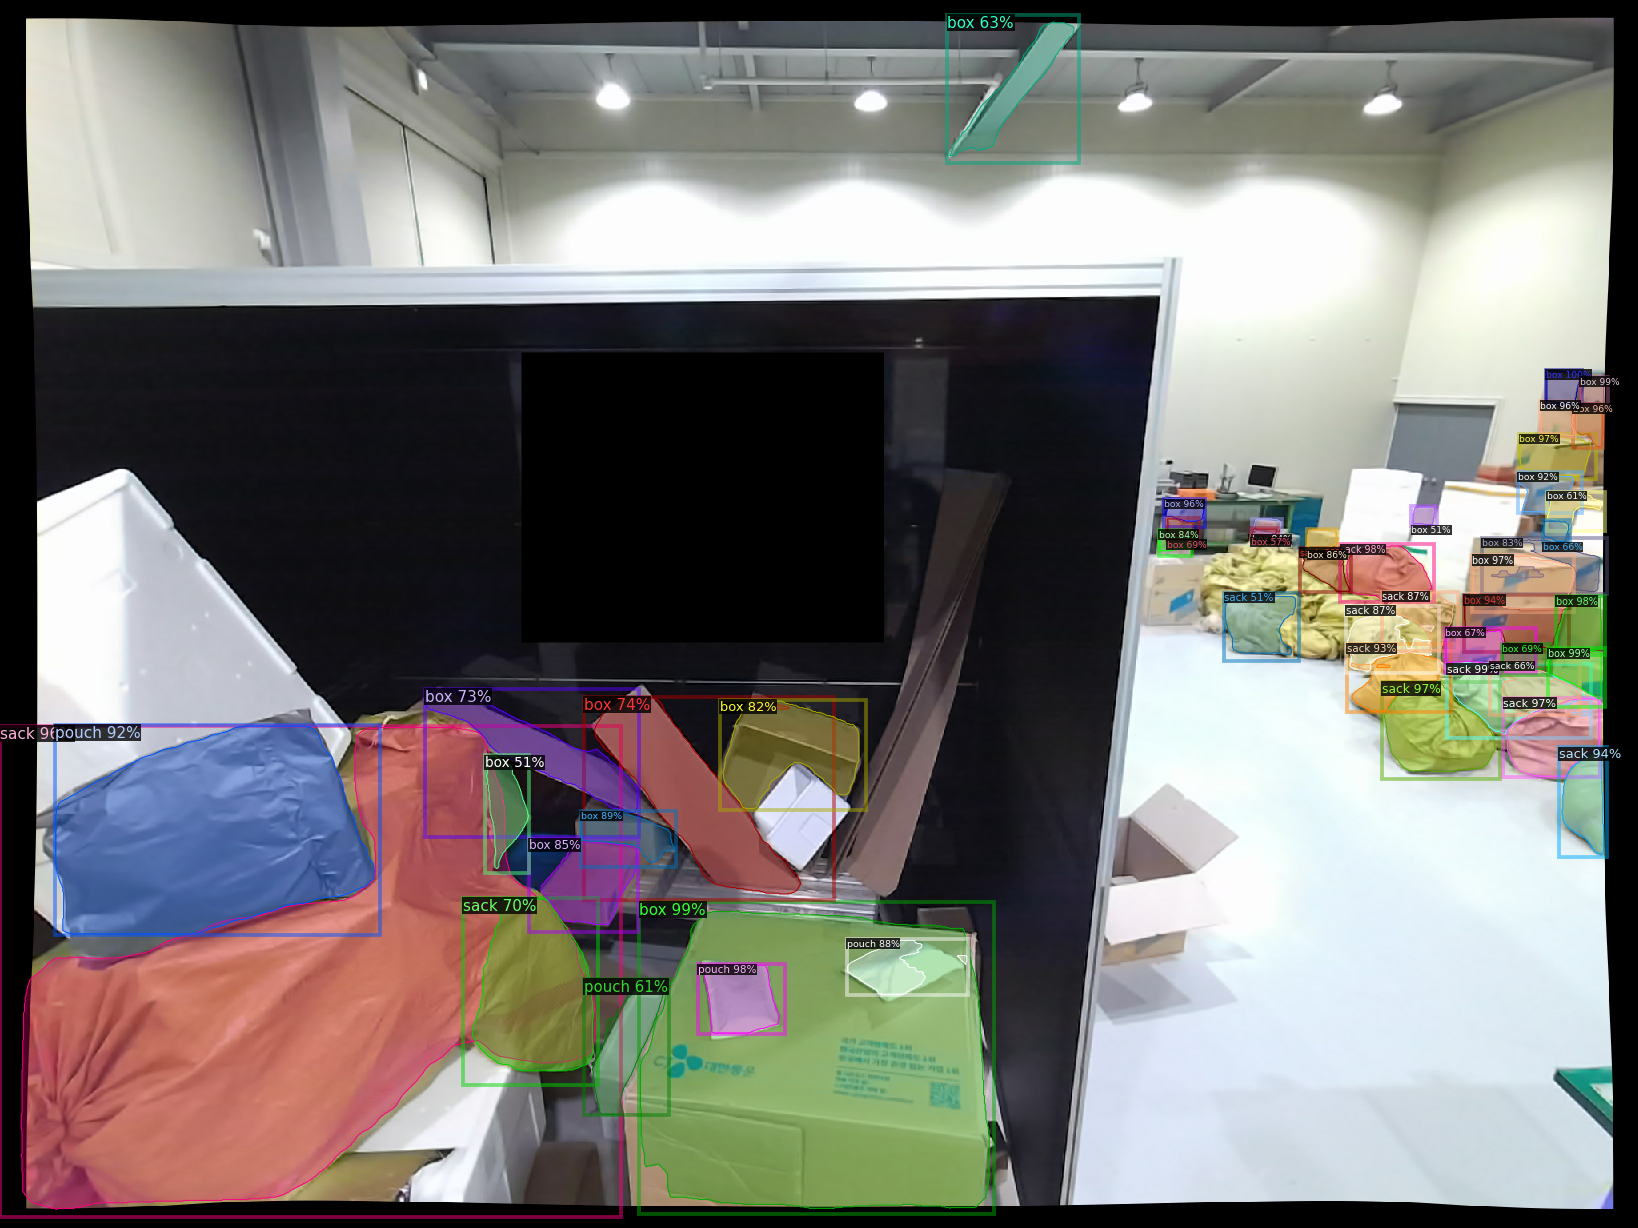

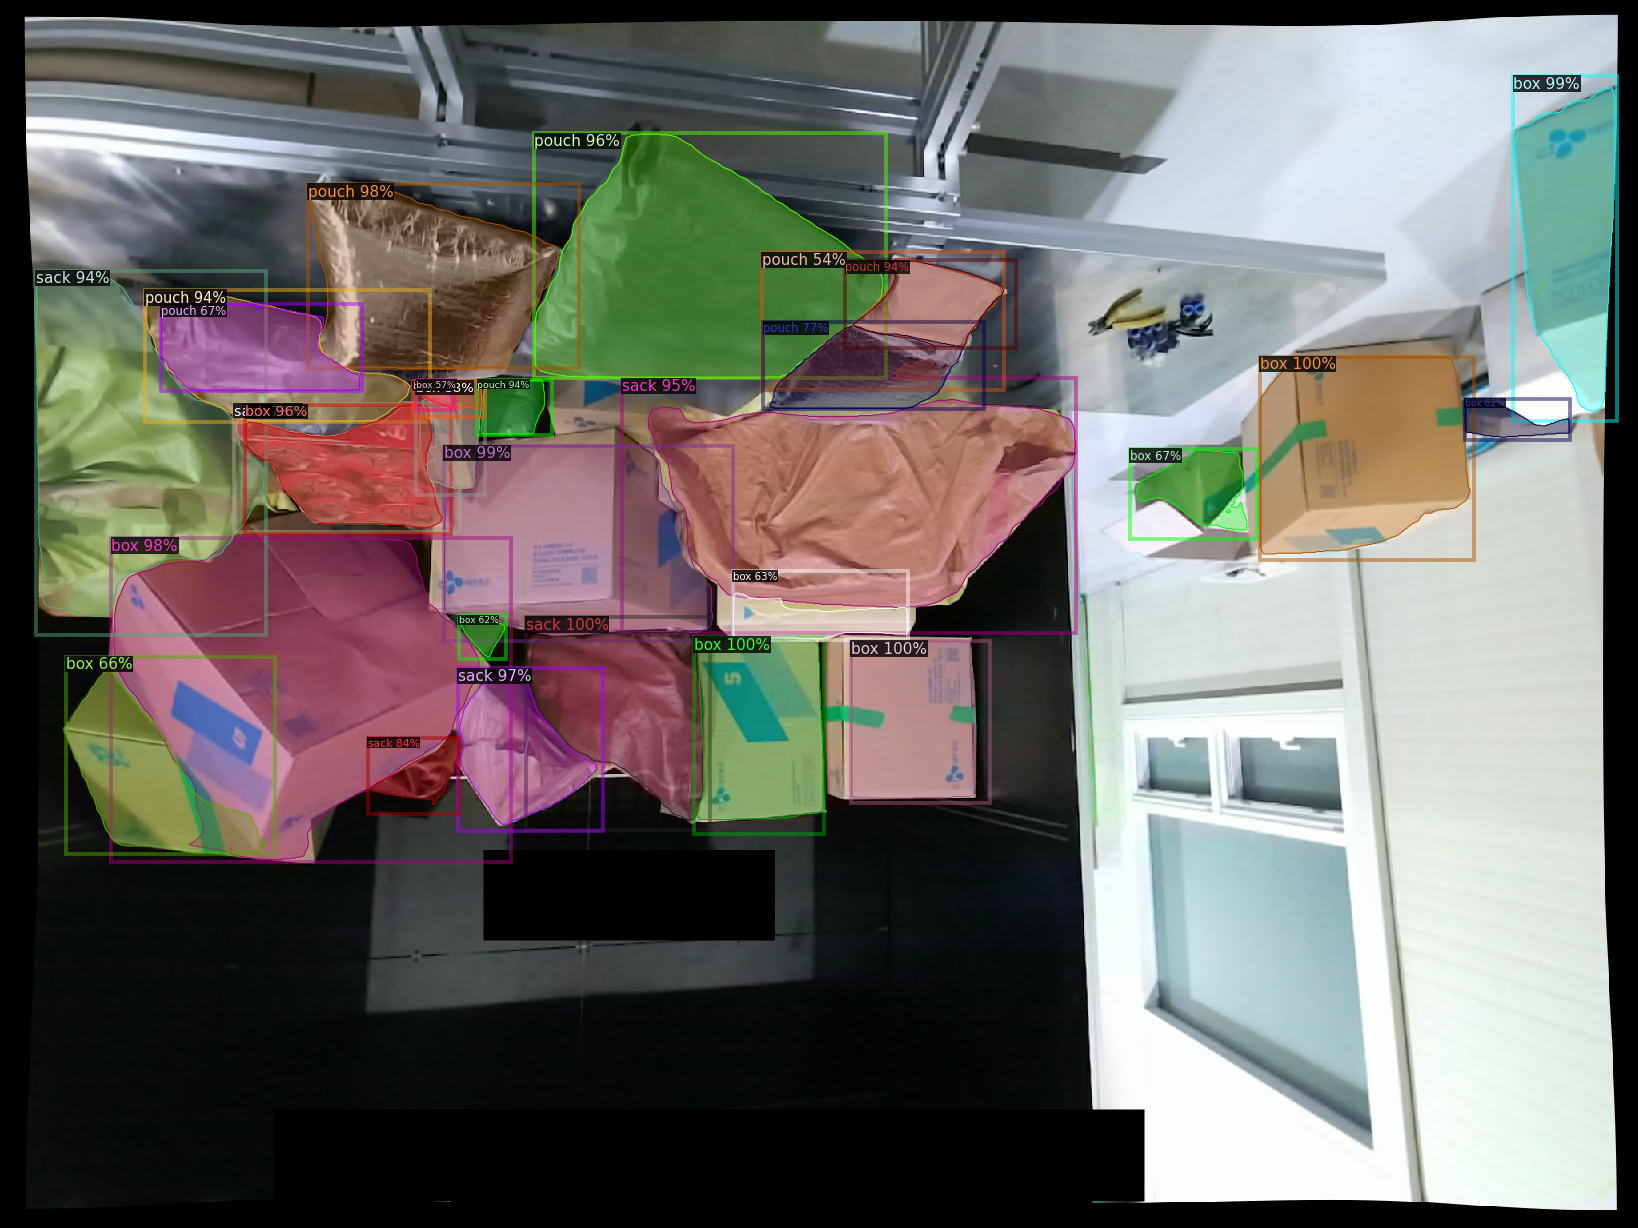

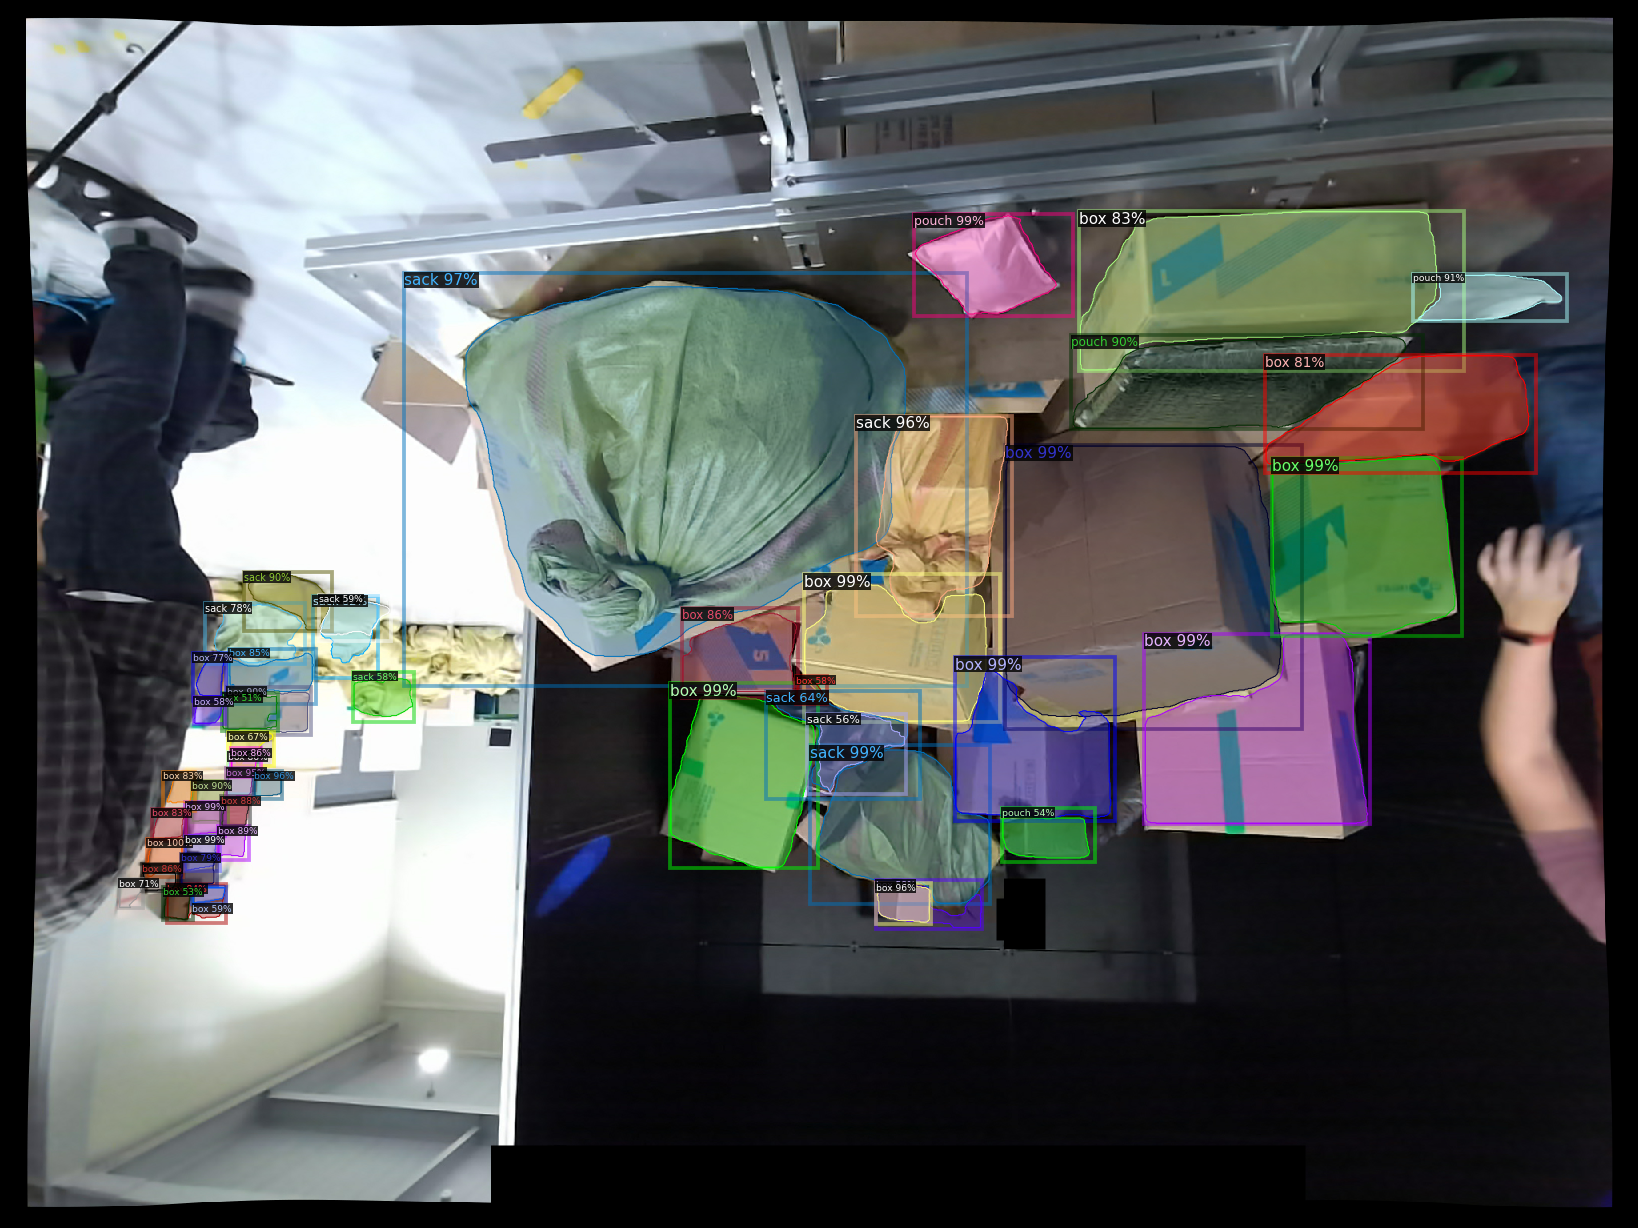

In [13]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=fruits_nuts_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [14]:
fruits_nuts_metadata

Metadata(evaluator_type='coco', image_root='./data/images', json_file='./data/trainval.json', name='fruit_nuts2', thing_classes=['sack', 'pouch', 'box', 'icebox'], thing_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2, 4: 3})

## Benchmark inference speed

In [15]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.17,fps:6.06
